In [22]:
# Dominio espacial

rf = 43.0	# Tamaño del dominio espacial
dr = 0.02	# Resolución espacial

Nr = Int(rf/dr)	# Determinamos el número de pasos

f0 = 0.2	# Valor central del campo en t=0
alpha0_seed = 0.8591596820437711     # Semilla para arrancar Initial_Siddhartha.jl

0.8591596820437711

|-------------------------------------|
|---Calculando Estado de Equilibrio---|
|-------------------------------------|

alpha0 seed = 0.8591596820437711
alpha0 real = 0.8591596820437711


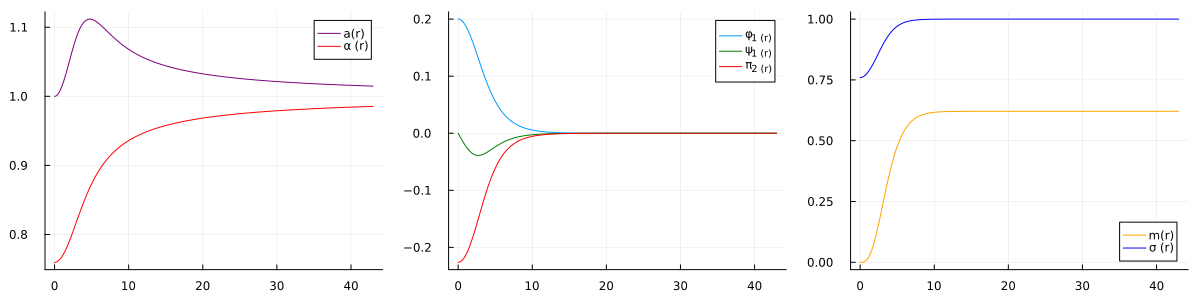

In [23]:
using DelimitedFiles
using Roots
using Plots

println("|-------------------------------------|")
println("|---Calculando Estado de Equilibrio---|")
println("|-------------------------------------|")

# Generación de malla r con Nr elementos
ϵ = 1e-6
r = [ϵ + k * dr for k in 0:Nr-1] # Desplazamos un chirri la malla para que no explote el solucionador.

# Sistema de ecuaciones
function Stationary_State(a, alpha, phi, psi, r)
    dln_a = (1-a^2)/(2r) + 0.5*r* (psi^2 + a^2*phi^2*(1+1/alpha^2))
    dln_alpha = (a^2-1)/r + dln_a - r*a^2*phi^2
    dphi = psi
    dpsi = -psi*(2/r + dln_alpha - dln_a) + a^2*phi*(1-1/alpha^2)

    return [a*dln_a, alpha*dln_alpha, dphi, dpsi]
end

# Algoritmo RK4
function RK4(a_n, alpha_n, phi_n, psi_n, r_n, dr)
    k1 = dr * Stationary_State(a_n, alpha_n, phi_n, psi_n, r_n)
    k2 = dr * Stationary_State(a_n + 0.5*k1[1],
                              alpha_n + 0.5*k1[2],
                              phi_n + 0.5*k1[3],
                              psi_n + 0.5*k1[4], r_n + 0.5*dr)
    k3 = dr * Stationary_State(a_n + 0.5*k2[1],
                              alpha_n + 0.5*k2[2],
                              phi_n + 0.5*k2[3],
                              psi_n + 0.5*k2[4], r_n + 0.5*dr)
    k4 = dr * Stationary_State(a_n + k3[1],
                              alpha_n + k3[2],
                              phi_n + k3[3],
                              psi_n + k3[4], r_n + dr)
    # Siguiente paso
    a_N = a_n + (k1[1] + 2*k2[1]+2*k3[1]+k4[1])/6
    alpha_N = alpha_n + (k1[2] + 2*k2[2]+2*k3[2]+k4[2])/6
    phi_N = phi_n + (k1[3] + 2*k2[3]+2*k3[3]+k4[3])/6
    psi_N = psi_n + (k1[4] + 2*k2[4]+2*k3[4]+k4[4])/6

    return (a_N, alpha_N, phi_N, psi_N)
end

function Solver(f0, alpha0) # variables de Inicialización o arranque

    # Inicialización de arreglos solución
    a = zeros(Float64, Nr)
    alpha = zeros(Float64, Nr)
    phi = zeros(Float64, Nr)
    psi = zeros(Float64, Nr)

    # Condiciones iniciales
    a[1] = 1.0
    alpha[1] = alpha0
    phi[1] = f0
    psi[1] = 0

    # Ciclo solucionador
    for k in 1:Nr-1
        a[k+1], alpha[k+1], phi[k+1], psi[k+1] = RK4(a[k], alpha[k], phi[k], psi[k], r[k], dr)
    end
    return a, alpha, phi, psi
end


# Función de error a minimizar
function error(f0, alpha0)
    _, _, phi, _ = Solver(f0, alpha0)
    return phi[end] # Ultimo valor de phi el cual queremos hacer cero
end


# Encontrando el valor correcto
alpha0_real = find_zero(alpha0 -> error(f0, alpha0), alpha0_seed)

# Encontrando la solución
a, alphajor, phi1, psi1 = Solver(f0, alpha0_real) # Esta no es la alpha chida

# Obteniendo el último valor de alpha
alpha_infinito = 1/ (a[end]*alphajor[end])

# a = (PALOMITA)
alpha = alpha_infinito .* alphajor
# phi1 = (PALOMITA)
phi2 = zeros(Float64, Nr)
# psi1 = (PALOMITA)
psi2 = zeros(Float64, Nr)
pi1 = zeros(Float64, Nr)
pi2 = @. - alpha0_real * a * phi1 / alpha

# Función de masa de Schwarzschild
m = [ri/2 * (1 - 1/ai^2) for (ri, ai) in zip(r, a)]

# Verificando si el producto da 1
Sigmata = a .* alpha

println()
println("alpha0 seed = ", alpha0_seed)
println("alpha0 real = ", alpha0_real)

# Graficanding

plt_static = plot(layout = (1, 3), size = (1200, 300))

plot!(plt_static[1], r, a, xlabel="r", label = "a(r)", linecolor=:purple)
plot!(plt_static[1], r, alpha, xlabel="r", label =  raw"\alpha (r)", linecolor=:red)

plot!(plt_static[2], r, phi1, xlabel="r", label = raw"\phi_1 (r)")
plot!(plt_static[2], r, psi1, xlabel="r", label = raw"\psi_1 (r)", linecolor=:green)
plot!(plt_static[2], r, pi2, xlabel="r", label = raw"\pi_2 (r)", linecolor=:red)

plot!(plt_static[3], r, m, xlabel="r", label = "m(r)", linecolor=:orange)
plot!(plt_static[3], r, Sigmata, xlabel="r", label =  raw"\sigma (r)", linecolor=:blue)

display(plt_static)



In [29]:
using Trapz

println("|------------------------------------------|")
println("|--- Parámetros del Estado de Equilibrio---|")
println("|------------------------------------------|")
println()

# Radio
println("", rf)

# Valor central del campo
println("", f0)

# Omega chida (sólo hay una)
println("", alpha0_real)

# Masa ADM
masa_ADM = m[end]
println("", masa_ADM)

# Corriente de Norther
j0 = @. -4*pi * r^4 * phi1^2 * a / alpha

# Carga conservada con Trapz
N = trapz(r, j0)
println("", N)

# 99% de la masa ADM
m99 = 0.99*m[end]
counter = findfirst(x -> x >= m99, m)
Masa_99 = m[counter]
println("", Masa_99)

# Radio en el que se concentra dicha cantidad de masa
Radio_99 = r[counter]
println("", Radio_99)

# Compacticidad
Compacticidad = Masa_99/Radio_99
println("", Compacticidad)

|------------------------------------------|
|--- Parámetros del Estado de Equilibrio---|
|------------------------------------------|

43.0
0.2
0.8591596820437711
0.6208828361931963
-164.17082409391216
0.6146784481723222
9.500001
0.06470298773361416
